In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import datetime as dt

# Step 1: Data Collection

# Load historical data for EUR/USD, GBP/USD, 10Y and 30Y Treasury up to today
end_date = dt.datetime.now().strftime('%Y-%m-%d')  # Today's date as end date
eur_usd = yf.download('EURUSD=X', start='2010-01-01', end=end_date)['Close']
gbp_usd = yf.download('GBPUSD=X', start='2010-01-01', end=end_date)['Close']
treasury_10y = yf.download('^TNX', start='2010-01-01', end=end_date)['Close']
treasury_30y = yf.download('^TYX', start='2010-01-01', end=end_date)['Close']

# Calculate the 10Y-30Y yield spread
yield_spread = treasury_10y - treasury_30y

# Combine the data into a single DataFrame
data = pd.DataFrame({
    'EUR/USD': eur_usd,
    'GBP/USD': gbp_usd,
    '10Y Treasury': treasury_10y,
    '30Y Treasury': treasury_30y,
    '10Y-30Y Spread': yield_spread
})

# Drop any rows with missing values
data.dropna(inplace=True)

# Step 2: Data Preprocessing

# Create lagged features (e.g., use past 3 days' data to predict the next day)
lags = 10
for col in data.columns:
    for lag in range(1, lags + 1):
        data[f'{col}_lag{lag}'] = data[col].shift(lag)

# Drop rows with missing values due to lagging
data.dropna(inplace=True)

# Define features and target variable
X = data  # Features (all columns except USD/JPY)
y = yf.download('JPY=X', start='2010-01-01', end=end_date)['Close']  # Target (USD/JPY)

# Align y with the lagged X data
y = y.iloc[lags:]  # Adjust for the number of lags

# Ensure the dataframes are aligned after lagging
X = X.iloc[lags:]

# Make sure X and Y have the same number of rows

# Fix the date misalignment
y = y[X.index]
assert X.shape[0] == y.shape[0]
# Normalize the features


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:

# Step 3: Split Data into Train and Test Sets

# Use data before 2024 as the training set, and 2024 data as the test set
train_end_date = '2023-12-31'
X_train, X_test = X[:train_end_date], X[train_end_date:]
y_train, y_test = y[:train_end_date], y[train_end_date:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Split the data into training and testing sets before 2024 as the training set, and 2024 data as the test set



(3494, 55) (168, 55) (3494,) (168,)


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best Parameters: {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.3, 'model__units': 100, 'optimizer': 'rmsprop'}
Best Score: 2.055212286005553


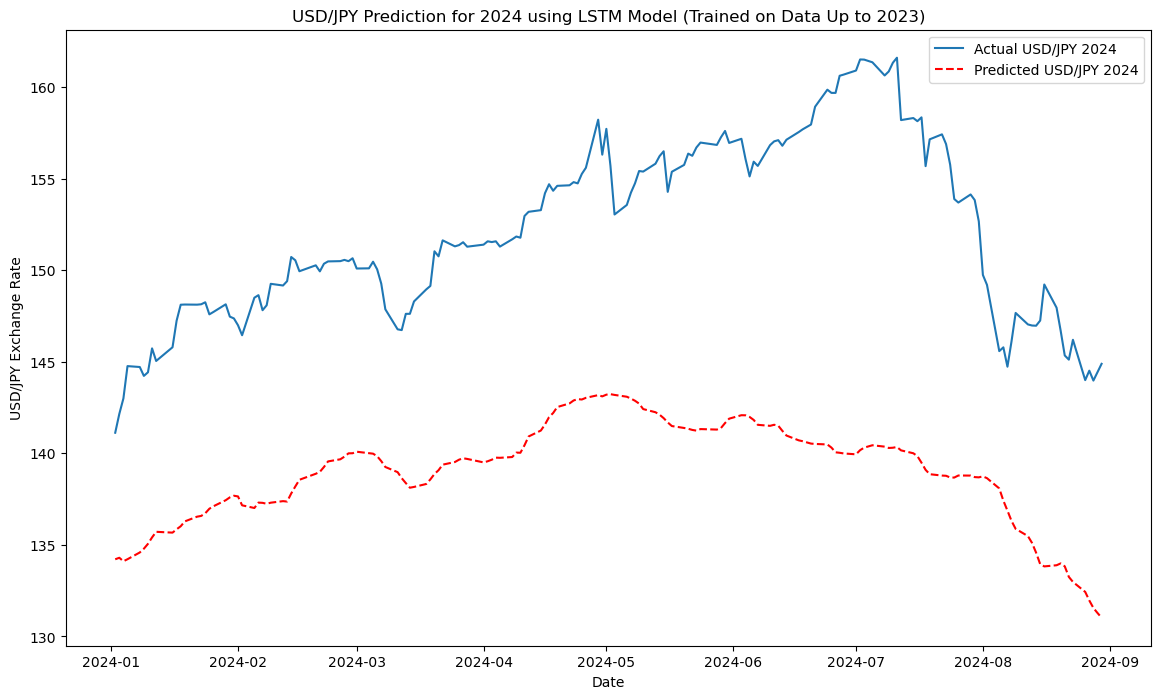

In [3]:

# Normalize the features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Normalize the target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape the features for LSTM (samples, time steps, features)
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Step 4: Model Definition

def create_model(units=50, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=25))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 5: Hyperparameter Tuning

# Wrap the model with KerasRegressor from SciKeras
model = KerasRegressor(model=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'model__units': [50, 100],
    'model__dropout_rate': [0.2, 0.3],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train_scaled, y_train_scaled)

# Print the best parameters and best score
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Score: {-grid_result.best_score_}")  # Convert negative MSE to positive for interpretation

# Step 6: Evaluate the Model on 2024 Data

# Retrieve the best model
best_model = grid_result.best_estimator_

# Predict the USD/JPY value for 2024 using the model
usd_jpy_predictions_2024_scaled = best_model.predict(X_test_scaled)
usd_jpy_predictions_2024 = scaler_y.inverse_transform(usd_jpy_predictions_2024_scaled.reshape(-1, 1)).flatten()

# Plot the predicted USD/JPY values vs. the actual USD/JPY values for 2024
plt.figure(figsize=(14, 8))
plt.plot(y_test.index, y_test, label='Actual USD/JPY 2024')
plt.plot(y_test.index, usd_jpy_predictions_2024, color='r', linestyle='--', label='Predicted USD/JPY 2024')
plt.title('USD/JPY Prediction for 2024 using LSTM Model (Trained on Data Up to 2023)')
plt.xlabel('Date')
plt.ylabel('USD/JPY Exchange Rate')
plt.legend()
plt.show()
